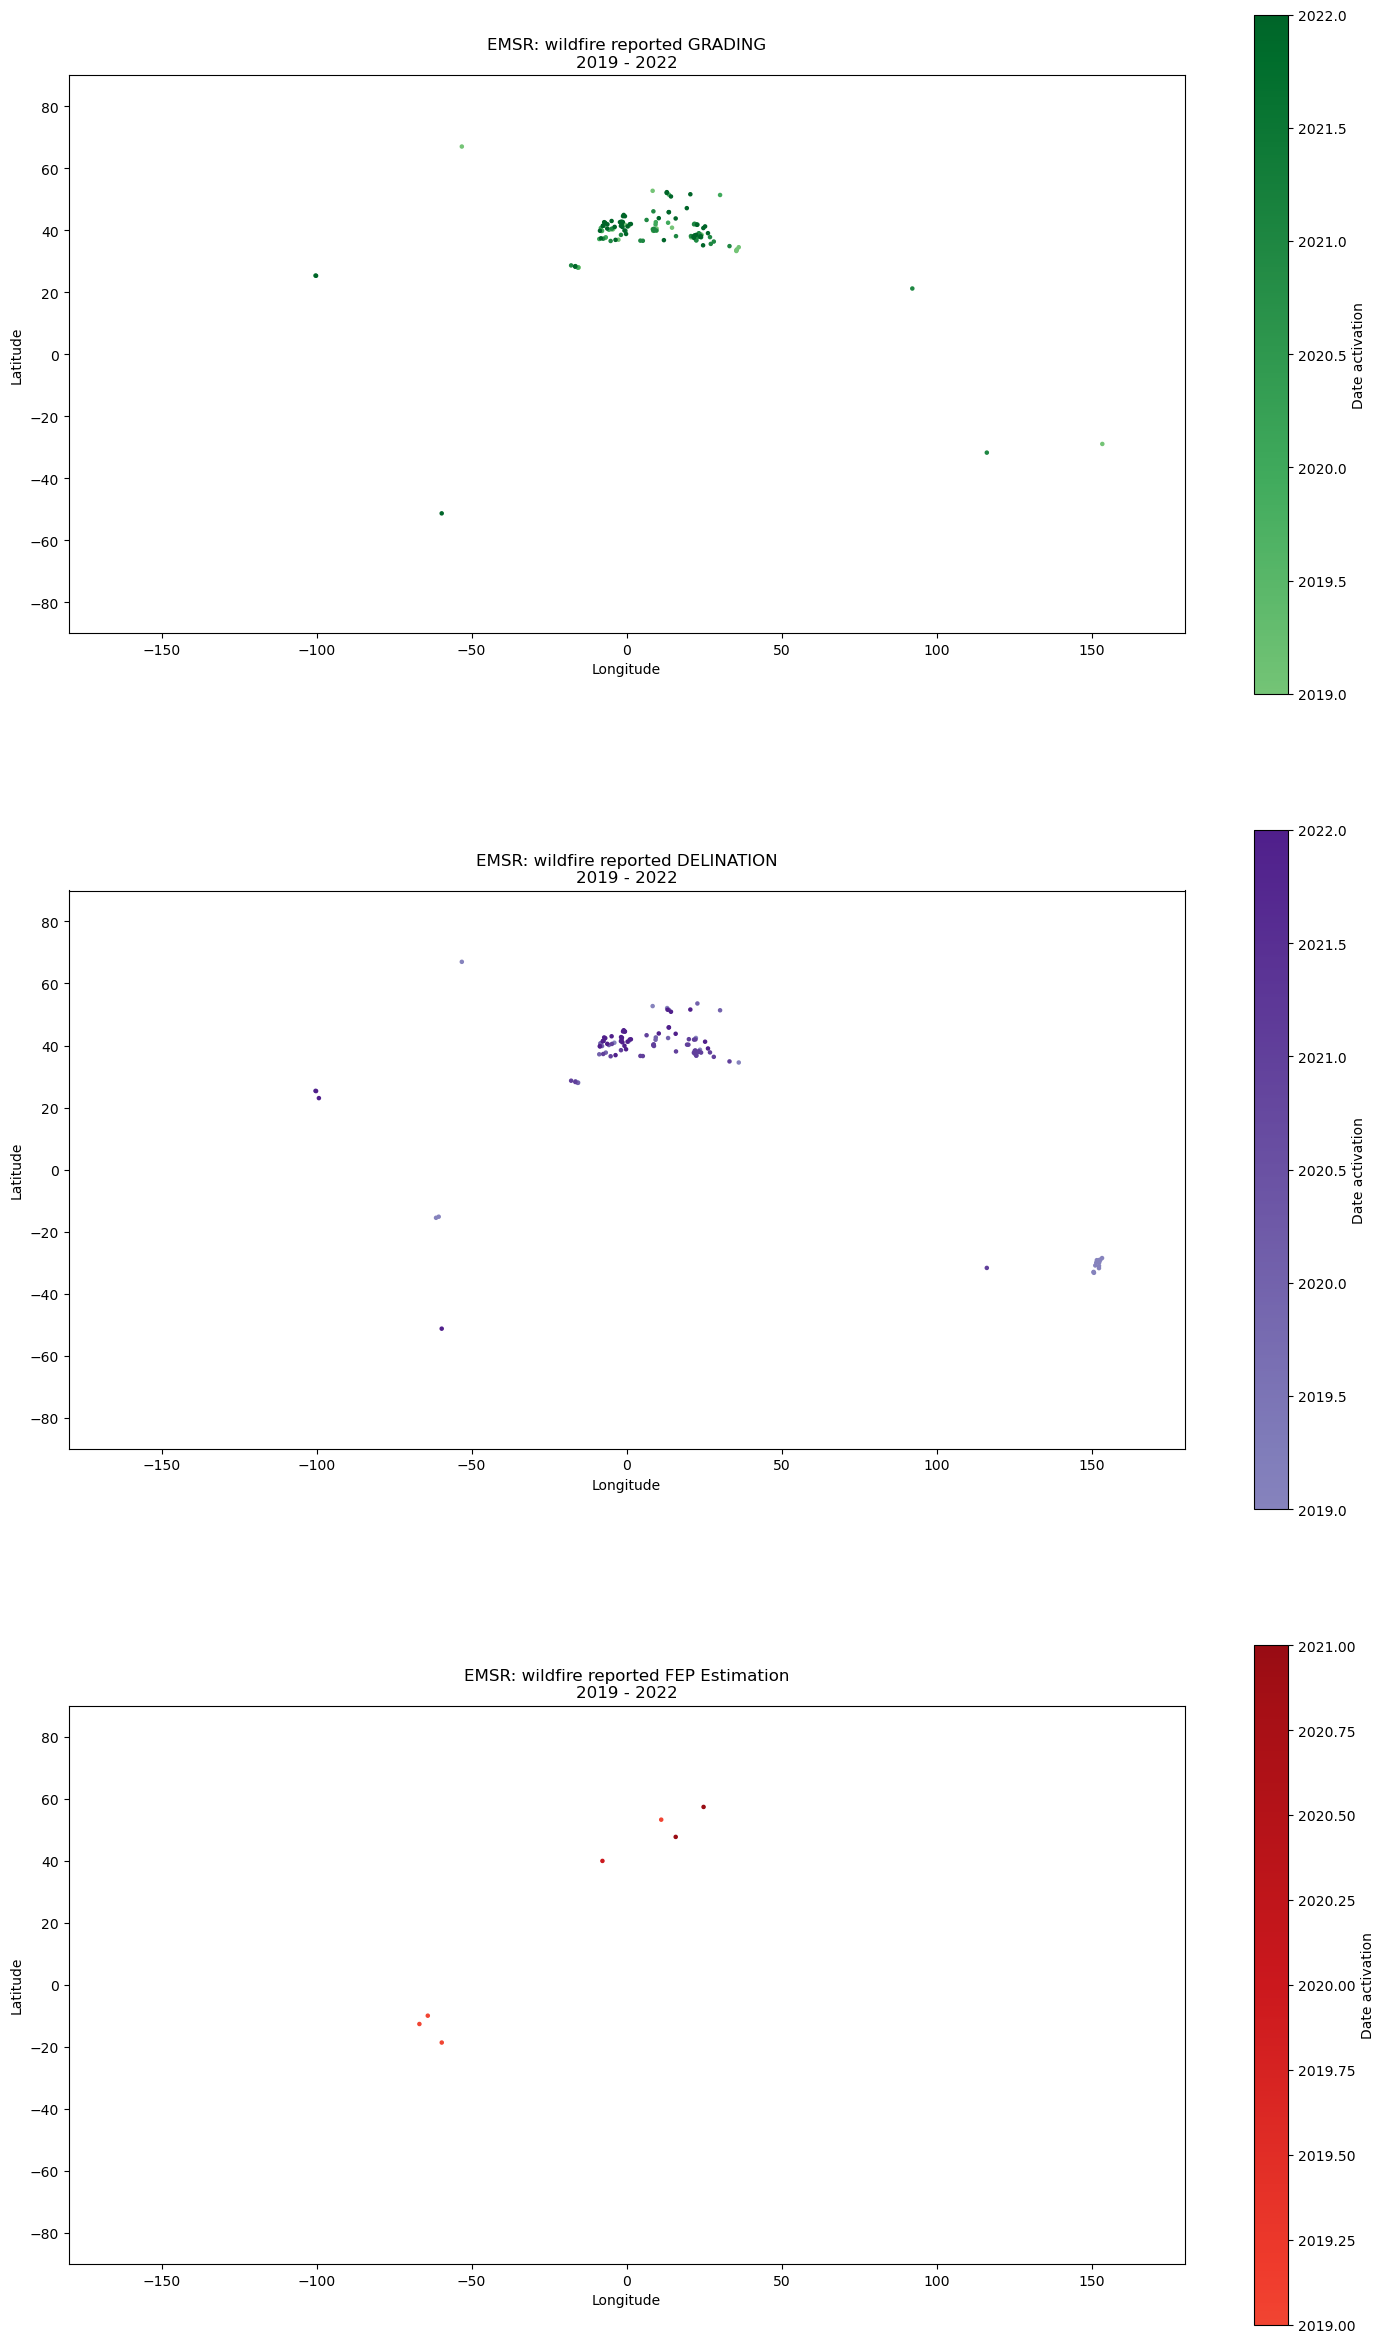

In [1]:
# read and plot data from CSV
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.colors as colors
from shapely.geometry import Polygon
import src.utils_variable as utils
import cartopy.feature as cfeature
from matplotlib import cm
from matplotlib.colors import ListedColormap
from shapely.geometry import LineString
from matplotlib.transforms import Bbox
from cartopy.feature import NaturalEarthFeature
# import datetime as dt

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv(utils.satelliteData, usecols=["EMSR","AOI","GRA","DEL","FEP","activationDate","centerBoxLong","centerBoxLat"], date_parser = pd.to_datetime, parse_dates=["activationDate"])

df["year"] = df["activationDate"].dt.year
df_GRA = df[df["GRA"] == 1].groupby(by=["EMSR", "AOI", "year"]).agg({"centerBoxLong":["mean"], "centerBoxLat":["mean"]}).reset_index()
df_GRA.columns = ["EMSR", "AOI", "year","centerBoxLong","centerBoxLat"]
df_GRA = df_GRA.reset_index()

df_DEL = df[df["DEL"] == 1].groupby(by=["EMSR", "AOI", "year"]).agg({"centerBoxLong":["mean"], "centerBoxLat":["mean"]}).reset_index()
df_DEL.columns = ["EMSR", "AOI", "year","centerBoxLong","centerBoxLat"]
df_DEL = df_DEL.reset_index()

df_FEP = df[df["FEP"] == 1].groupby(by=["EMSR", "AOI", "year"]).agg({"centerBoxLong":["mean"], "centerBoxLat":["mean"]}).reset_index()
df_FEP.columns = ["EMSR", "AOI", "year","centerBoxLong","centerBoxLat"]
df_FEP = df_FEP.reset_index()


# Creating axes and plotting world map
fig, ax = plt.subplots(3, figsize=(18, 30))

# Plotting our Impact Energy data with a color map
longGRA = df_GRA['centerBoxLong']
latGRA = df_GRA['centerBoxLat']
dateGRA = df_GRA["year"]

longDEL = df_DEL['centerBoxLong']
latDEL = df_DEL['centerBoxLat']
dateDEL = df_DEL["year"]

longFEP = df_FEP['centerBoxLong']
latFEP = df_FEP['centerBoxLat']
dateFEP = df_FEP["year"]

# From GeoPandas, our world map data
# worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Extract the coastline geometry using cartopy.feature.COASTLINE
coastline = cfeature.COASTLINE
# coastline = cfeature.NaturalEarthFeature(category='physical', scale='10m', facecolor='none', name='coastline')

# Convert MultiLineString to a list of LineString geometries
lines = []
for line in coastline.geometries():
    lines.append(line)

# Create a GeoDataFrame with the LineString geometries
worldmap = gpd.GeoDataFrame(geometry=[LineString(line.coords) for line in lines])

#GRA
greens = cm.get_cmap('Greens', 512)
newcmp = ListedColormap(greens(np.linspace(0.50, 0.9, 256)))

worldmap.plot(color="black", linewidth=0.3, ax=ax[0])
mapGRA = ax[0].scatter(longGRA, latGRA, c=dateGRA, s=5, alpha=1, cmap=newcmp)
plt.colorbar(mappable = mapGRA, label='Date activation', ax=ax[0])

ax[0].set_xlim([-180, 180])
ax[0].set_ylim([-90, 90])

first_year = df["activationDate"].min().strftime("%Y")
last_year = df["activationDate"].max().strftime("%Y")
ax[0].set_title("EMSR: wildfire reported GRADING\n" + str(first_year) + " - " + str(last_year))
ax[0].set_xlabel("Longitude")
ax[0].set_ylabel("Latitude")

#DEL
purples = cm.get_cmap('Purples', 512)
newcmp = ListedColormap(purples(np.linspace(0.60, 0.9, 256)))

worldmap.plot(color="black", linewidth=0.3,  ax=ax[1])
mapDEL = ax[1].scatter(longDEL, latDEL, c=dateDEL, s=5, alpha=1, cmap=newcmp)
plt.colorbar(mappable = mapDEL, label='Date activation', ax=ax[1])

ax[1].set_xlim([-180, 180])
ax[1].set_ylim([-90, 90])

first_year = df["activationDate"].min().strftime("%Y")
last_year = df["activationDate"].max().strftime("%Y")
ax[1].set_title("EMSR: wildfire reported DELINATION\n" + str(first_year) + " - " + str(last_year))
ax[1].set_xlabel("Longitude")
ax[1].set_ylabel("Latitude")

#FEP
reds = cm.get_cmap('Reds', 512)
newcmp = ListedColormap(reds(np.linspace(0.60, 0.9, 256)))

worldmap.plot(color="black", linewidth=0.3,  ax=ax[2])
mapFEP = ax[2].scatter(longFEP, latFEP, c=dateFEP, s=5, alpha=1, cmap=newcmp)
plt.colorbar(mappable = mapFEP, label='Date activation', ax=ax[2])

ax[2].set_xlim([-180, 180])
ax[2].set_ylim([-90, 90])

first_year = df["activationDate"].min().strftime("%Y")
last_year = df["activationDate"].max().strftime("%Y")
ax[2].set_title("EMSR: wildfire reported FEP Estimation\n" + str(first_year) + " - " + str(last_year))
ax[2].set_xlabel("Longitude")
ax[2].set_ylabel("Latitude")

# Save each subplot as a separate file
# for i, axs in enumerate(ax):
#     filename = f'{utils.imagesFolder}world_map_{i+1}.png'
#     axs.figure.savefig(filename, bbox_inches='tight')

for i, _ax in enumerate(ax):
    _ax.figure.canvas.draw()
    items = _ax.get_xticklabels() + _ax.get_yticklabels() 
    #    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    items += [_ax, _ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])

    # Save just the portion _inside_ the second axis's boundaries
    extent = bbox.expanded(1.3, 1.1).transformed(fig.dpi_scale_trans.inverted())
    
    if i == 0:
        _type = "GRA"
    elif i == 1:
        _type = "DEL"
    else:
        _type = "FEP"

    filename = f'{utils.imagesFolder}world_map_{_type}.svg'
    fig.savefig(filename, bbox_inches=extent)

plt.savefig(utils.imagesFolder + "distributionWorldAll.svg")
plt.show()

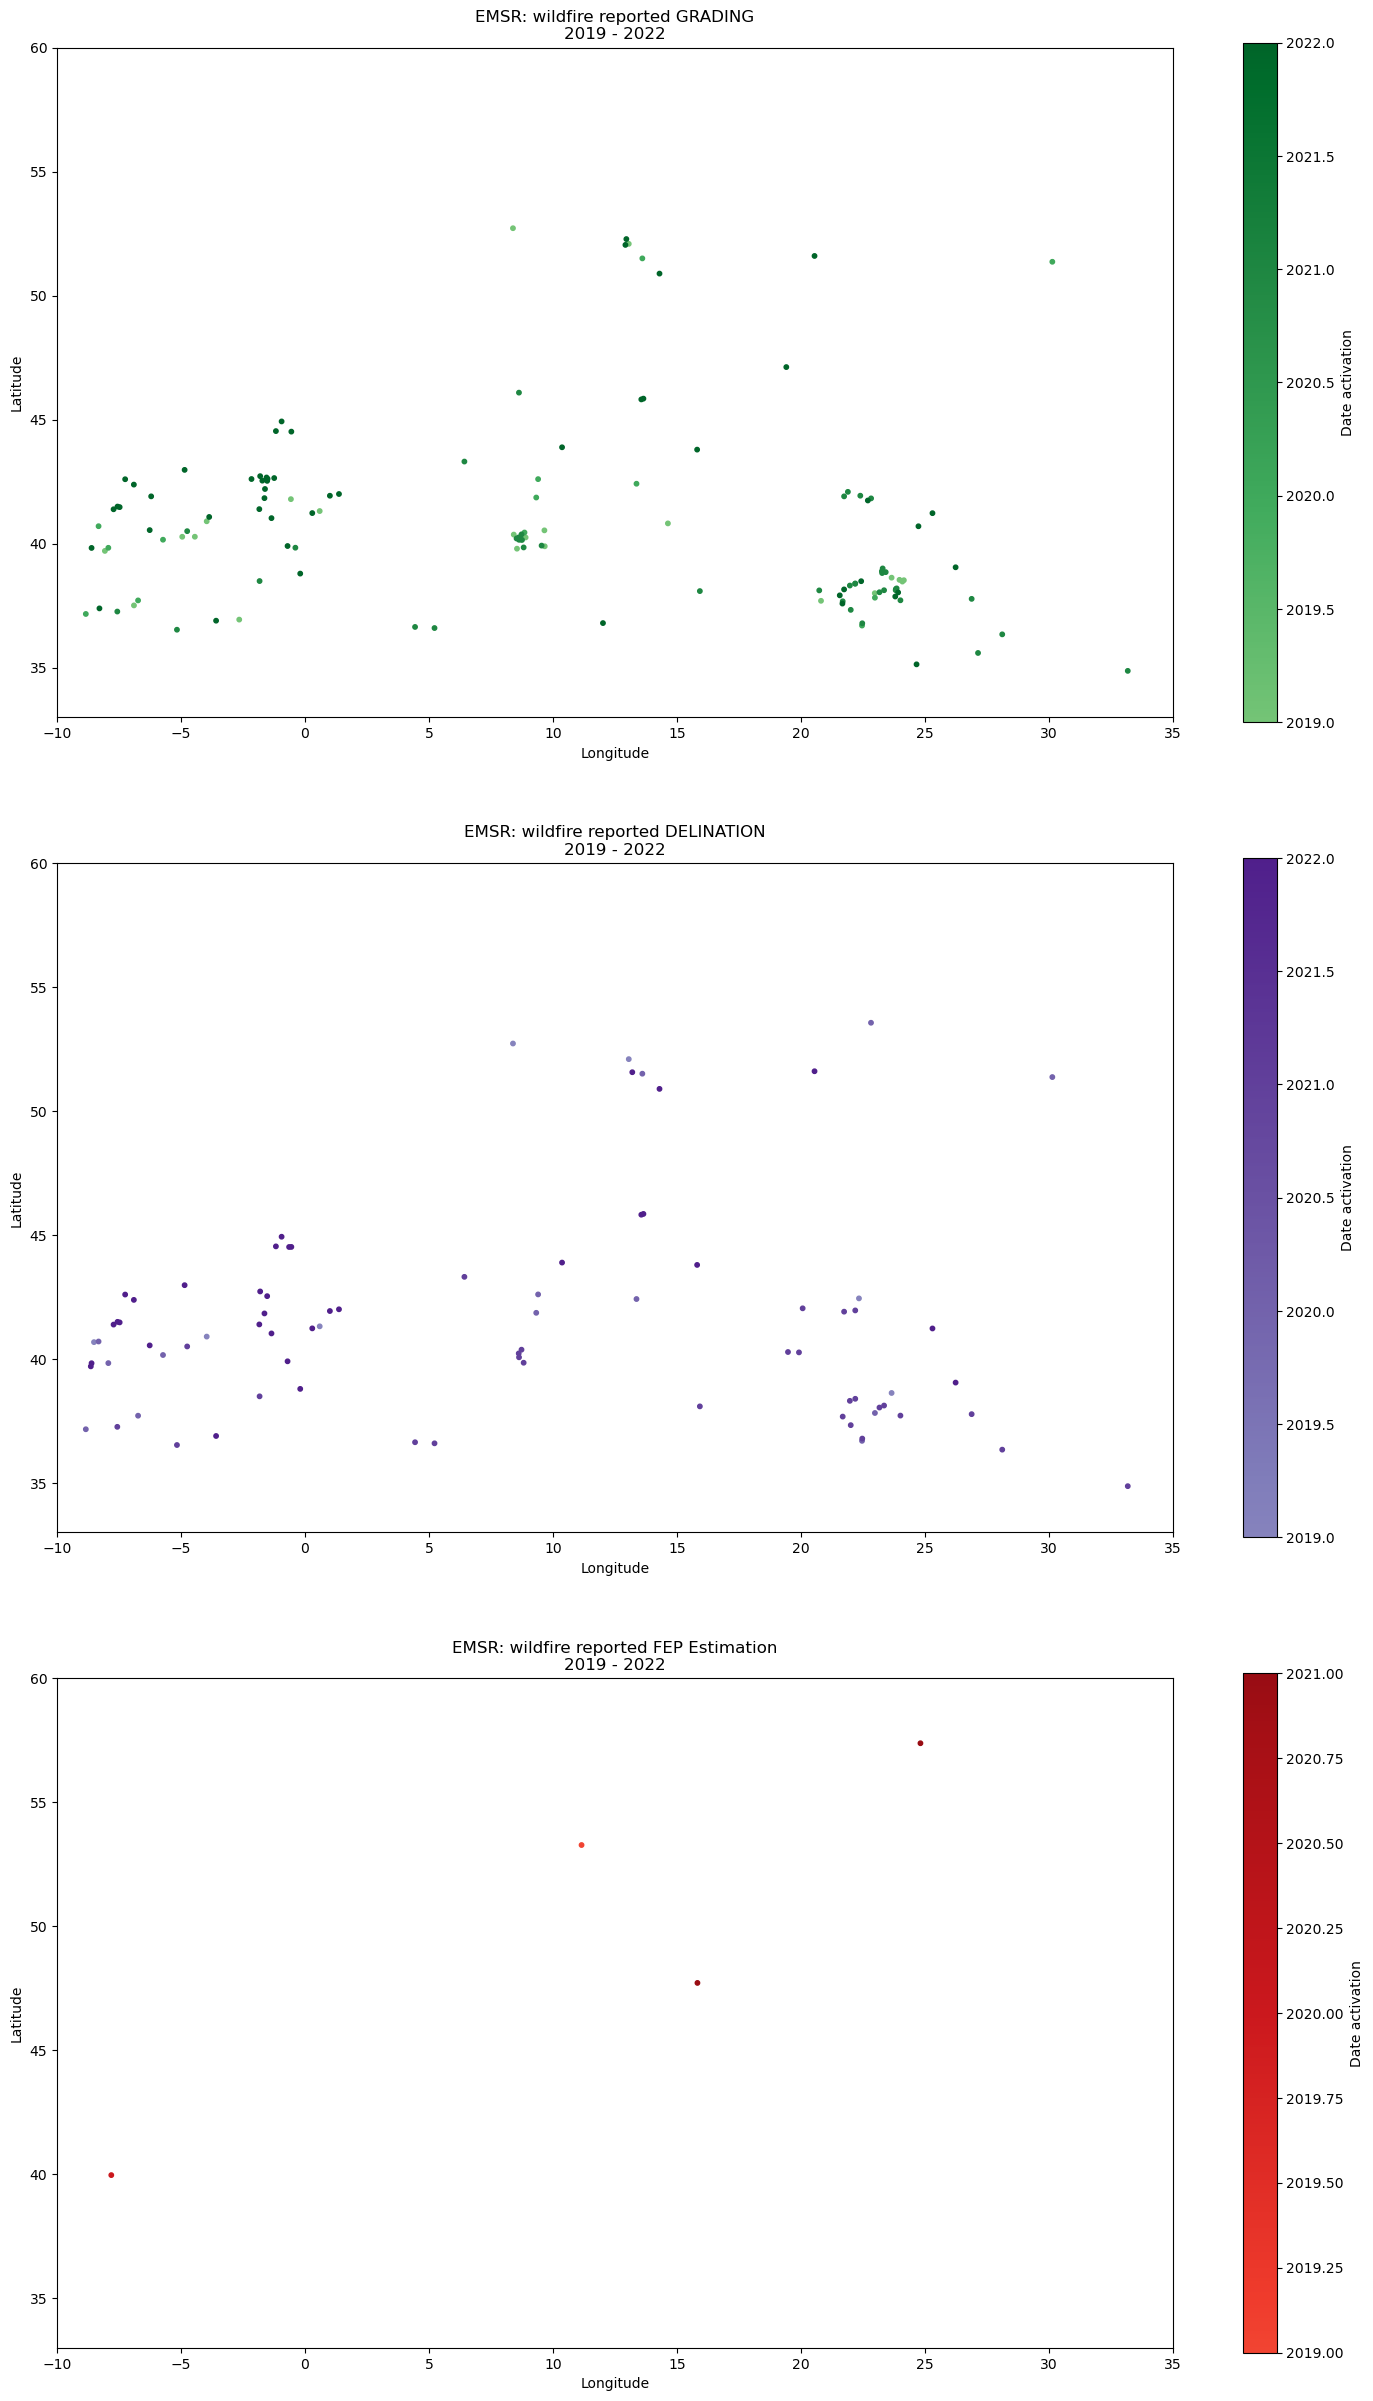

In [2]:
# From GeoPandas, our world map data
# https://towardsdatascience.com/geoplotting-emissions-intensity-of-electricity-generation-in-europe-90c22b378858

# worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Extract the coastline geometry using cartopy.feature.COASTLINE
coastline = cfeature.COASTLINE

# Convert MultiLineString to a list of LineString geometries
lines = []
for line in coastline.geometries():
    lines.append(line)

# Create a GeoDataFrame with the LineString geometries
worldmap = gpd.GeoDataFrame(geometry=[LineString(line.coords) for line in lines])

polygon = Polygon([(-10, 33), (35, 33), (35, 60),(-10, 60)])
europe = gpd.clip(worldmap, polygon)

# Creating axes and plotting world map
fig, ax = plt.subplots(3, figsize=(18, 30))

# consider only europe
df_GRA = df_GRA.loc[(df_GRA['centerBoxLong'].between(-10, 45, inclusive=False) & df_GRA['centerBoxLat'].between(33, 60, inclusive=False))]
longGRA = df_GRA['centerBoxLong']
latGRA = df_GRA['centerBoxLat']
dateGRA = df_GRA["year"]

df_DEL = df_DEL.loc[(df_DEL['centerBoxLong'].between(-10, 45, inclusive=False) & df_DEL['centerBoxLat'].between(33, 60, inclusive=False))]
longDEL = df_DEL['centerBoxLong']
latDEL = df_DEL['centerBoxLat']
dateDEL = df_DEL["year"]

df_FEP = df_FEP.loc[(df_FEP['centerBoxLong'].between(-10, 45, inclusive=False) & df_FEP['centerBoxLat'].between(33, 60, inclusive=False))]
longFEP = df_FEP['centerBoxLong']
latFEP = df_FEP['centerBoxLat']
dateFEP = df_FEP["year"]

#GRA
greens = cm.get_cmap('Greens', 512)
newcmp = ListedColormap(greens(np.linspace(0.50, 0.9, 256)))

europe.plot(color="black", linewidth=0.3, ax=ax[0])
mapGRA = ax[0].scatter(longGRA, latGRA, c=dateGRA, s=10, alpha=1, cmap=newcmp)
plt.colorbar(mappable = mapGRA, label='Date activation', ax=ax[0])

ax[0].set_xlim([-10, 35])
ax[0].set_ylim([33, 60])

first_year = df["activationDate"].min().strftime("%Y")
last_year = df["activationDate"].max().strftime("%Y")
ax[0].set_title("EMSR: wildfire reported GRADING\n" + str(first_year) + " - " + str(last_year))
ax[0].set_xlabel("Longitude")
ax[0].set_ylabel("Latitude")

#DEL
purples = cm.get_cmap('Purples', 512)
newcmp = ListedColormap(purples(np.linspace(0.60, 0.9, 256)))

europe.plot(color="black", linewidth=0.3, ax=ax[1])
mapDEL = ax[1].scatter(longDEL, latDEL, c=dateDEL, s=10, alpha=1, cmap=newcmp)
plt.colorbar(mappable = mapDEL, label='Date activation', ax=ax[1])

ax[1].set_xlim([-10, 35])
ax[1].set_ylim([33, 60])

first_year = df["activationDate"].min().strftime("%Y")
last_year = df["activationDate"].max().strftime("%Y")
ax[1].set_title("EMSR: wildfire reported DELINATION\n" + str(first_year) + " - " + str(last_year))
ax[1].set_xlabel("Longitude")
ax[1].set_ylabel("Latitude")

#FEP
reds = cm.get_cmap('Reds', 512)
newcmp = ListedColormap(reds(np.linspace(0.60, 0.9, 256)))

europe.plot(color="black", linewidth=0.3, ax=ax[2])
mapFEP = ax[2].scatter(longFEP, latFEP, c=dateFEP, s=10, alpha=1, cmap=newcmp)
plt.colorbar(mappable = mapFEP, label='Date activation', ax=ax[2])

ax[2].set_xlim([-10, 35])
ax[2].set_ylim([33, 60])

first_year = df["activationDate"].min().strftime("%Y")
last_year = df["activationDate"].max().strftime("%Y")
ax[2].set_title("EMSR: wildfire reported FEP Estimation\n" + str(first_year) + " - " + str(last_year))
ax[2].set_xlabel("Longitude")
ax[2].set_ylabel("Latitude")

for i, _ax in enumerate(ax):
    _ax.figure.canvas.draw()
    items = _ax.get_xticklabels() + _ax.get_yticklabels() 
    #    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    items += [_ax, _ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])

    # Save just the portion _inside_ the second axis's boundaries
    extent = bbox.expanded(1.3, 1.1).transformed(fig.dpi_scale_trans.inverted())
    
    if i == 0:
        _type = "GRA"
    elif i == 1:
        _type = "DEL"
    else:
        _type = "FEP"

    filename = f'{utils.imagesFolder}europe_map_{_type}.svg'
    fig.savefig(filename, bbox_inches=extent)


plt.savefig(utils.imagesFolder + "distributionEuropeAll.svg")
plt.show()

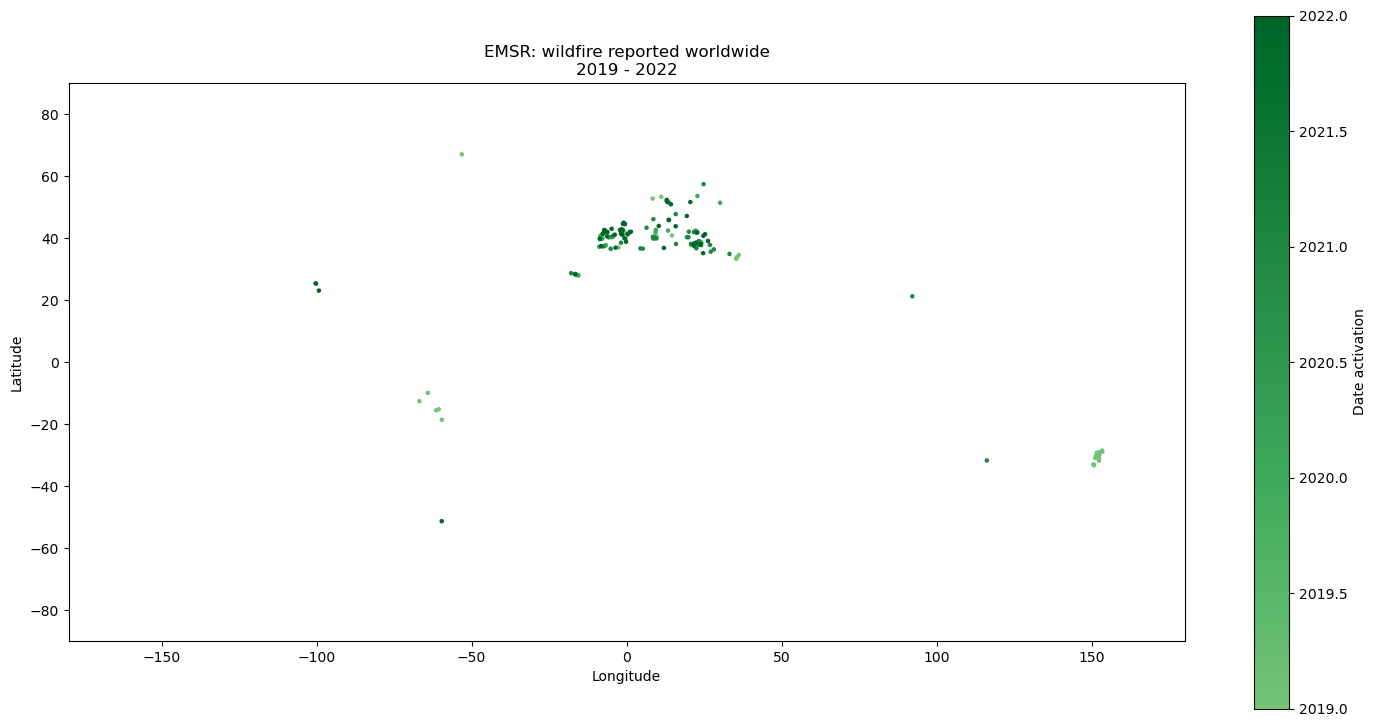

In [3]:
# read and plot data from CSV
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.colors as colors
from shapely.geometry import Polygon
import src.utils_variable as utils
import cartopy.feature as cfeature
from matplotlib import cm
from matplotlib.colors import ListedColormap
from shapely.geometry import LineString
from matplotlib.transforms import Bbox
# import datetime as dt


df = pd.read_csv(utils.satelliteData, usecols=["EMSR","AOI","GRA","DEL","FEP","activationDate","centerBoxLong","centerBoxLat"], date_parser = pd.to_datetime, parse_dates=["activationDate"])

df["year"] = df["activationDate"].dt.year
df_All = df.groupby(by=["EMSR", "AOI", "year"]).agg({"centerBoxLong":["mean"], "centerBoxLat":["mean"]}).reset_index()
df_All.columns = ["EMSR", "AOI", "year","centerBoxLong","centerBoxLat"]
df_All = df_All.reset_index()

# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(18, 9))

# Plotting our Impact Energy data with a color map
longAll = df_All['centerBoxLong']
latAll = df_All['centerBoxLat']
dateAll = df_All["year"]

# From GeoPandas, our world map data
# worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Extract the coastline geometry using cartopy.feature.COASTLINE
coastline = cfeature.COASTLINE

# Convert MultiLineString to a list of LineString geometries
lines = []
for line in coastline.geometries():
    lines.append(line)

# Create a GeoDataFrame with the LineString geometries
worldmap = gpd.GeoDataFrame(geometry=[LineString(line.coords) for line in lines])

#All
greens = cm.get_cmap('Greens', 512)
newcmp = ListedColormap(greens(np.linspace(0.50, 0.9, 256)))

worldmap.plot(color="black", linewidth=0.3, ax=ax)
mapAll = ax.scatter(longAll, latAll, c=dateAll, s=5, alpha=1, cmap=newcmp)
plt.colorbar(mappable = mapAll, label='Date activation', ax=ax)

ax.set_xlim([-180, 180])
ax.set_ylim([-90, 90])

first_year = df["activationDate"].min().strftime("%Y")
last_year = df["activationDate"].max().strftime("%Y")
ax.set_title("EMSR: wildfire reported worldwide\n" + str(first_year) + " - " + str(last_year))
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude") 

filename = f'{utils.imagesFolder}world_map_AllinOne.svg'

plt.savefig(filename)
plt.show()

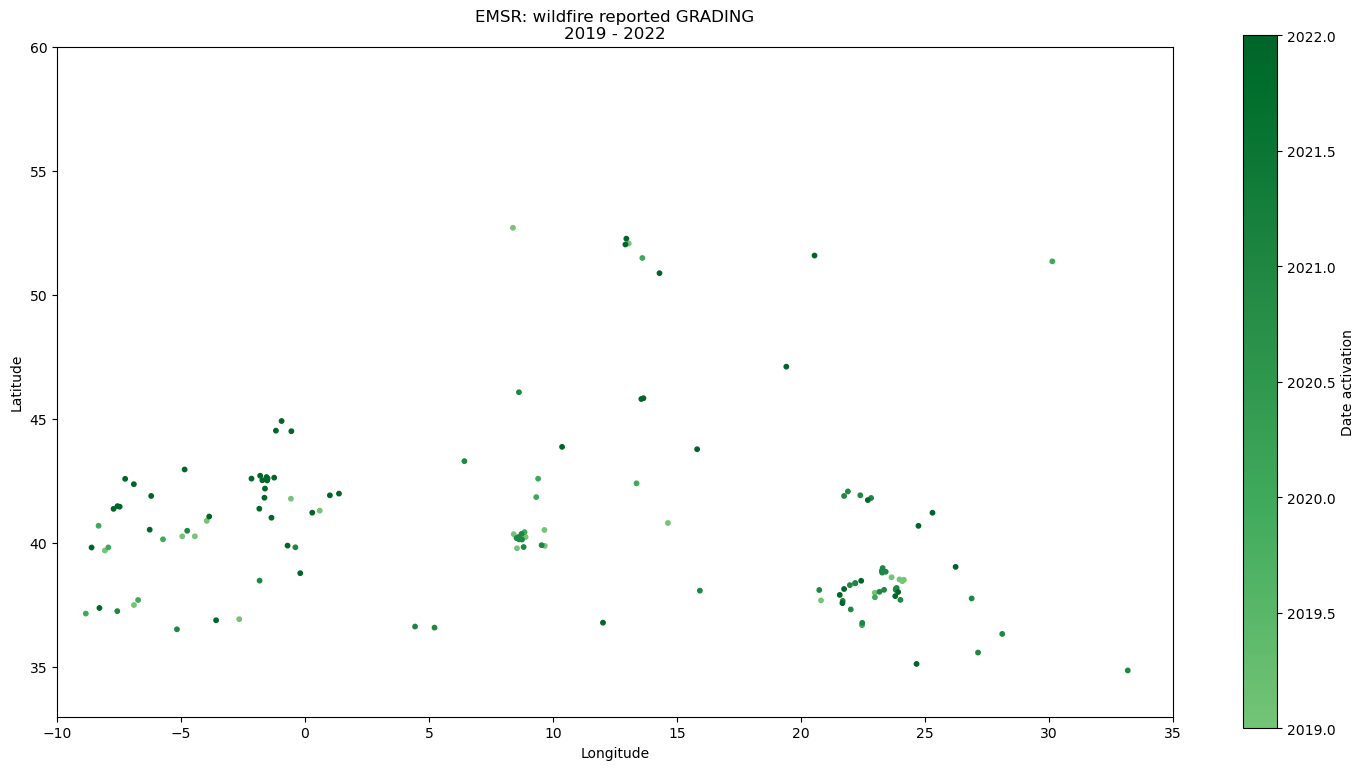

In [4]:
# From GeoPandas, our world map data
# https://towardsdatascience.com/geoplotting-emissions-intensity-of-electricity-generation-in-europe-90c22b378858

# worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Extract the coastline geometry using cartopy.feature.COASTLINE
coastline = cfeature.COASTLINE

# Convert MultiLineString to a list of LineString geometries
lines = []
for line in coastline.geometries():
    lines.append(line)

# Create a GeoDataFrame with the LineString geometries
worldmap = gpd.GeoDataFrame(geometry=[LineString(line.coords) for line in lines])

polygon = Polygon([(-10, 33), (35, 33), (35, 60),(-10, 60)])
europe = gpd.clip(worldmap, polygon)

# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(18, 9))

# consider only europe
df_All = df_All.loc[(df_All['centerBoxLong'].between(-10, 45, inclusive=False) & df_All['centerBoxLat'].between(33, 60, inclusive=False))]
longAll = df_All['centerBoxLong']
latAll = df_All['centerBoxLat']
dateAll = df_All["year"]

#All
greens = cm.get_cmap('Greens', 512)
newcmp = ListedColormap(greens(np.linspace(0.50, 0.9, 256)))

europe.plot(color="black", linewidth=0.3, ax=ax)
mapGRA = ax.scatter(longGRA, latGRA, c=dateGRA, s=10, alpha=1, cmap=newcmp)
plt.colorbar(mappable = mapGRA, label='Date activation', ax=ax)

ax.set_xlim([-10, 35])
ax.set_ylim([33, 60])

first_year = df["activationDate"].min().strftime("%Y")
last_year = df["activationDate"].max().strftime("%Y")
ax.set_title("EMSR: wildfire reported GRADING\n" + str(first_year) + " - " + str(last_year))
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

filename = f'{utils.imagesFolder}europe_map_AllinOne.svg'

plt.savefig(filename)
plt.show()